# Set up

In [82]:
!nvidia-smi

Mon Aug  8 01:03:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |   3637MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inference

Build dependencies

In [ ]:
%pip install --upgrade pip
%pip uninstall -y tensorflow numba
%pip install matplotlib\
tensorflow==1.15.2 \
numpy==1.19.3 \
inflect==0.2.5 \
librosa==0.6.0 \
Unidecode==1.0.22 \
pillow
%pip install janome==0.4.2
%pip install tensorflow==1.15.2 
# %pip install scipy==1.0.0 
%pip install denoiser==0.1.0
%pip install librosa==0.8.0
%pip install numba
%pip install pysoundfile==0.9.0.post1
%pip install unidecode==1.3.4
%pip install pyopenjtalk==0.2.0
%pip install inflect==5.6.2
%pip install janome==0.4.2

Clone repo

In [ ]:
!git clone https://github.com/Francis-Komizu/Tacotron2-Waveglow
%cd Tacotron2-Waveglow/

Download pre-trained model

In [ ]:
!mkdir pretrained
!gdown --id '1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA' --output pretrained/tacotron2_base.pt # pretrained Tacotron2 
!gdown --id '1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF' --output pretrained/wavglow_base # pretrained WaveGlow

Import packages

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser

In [7]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

Set up hyperparameters

In [8]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Load model form checkpoint

In [75]:
checkpoint_path = "/content/drive/MyDrive/Gal-TTS/waveglow-models/checkpoint_5000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

## Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
waveglow_path = '/content/Tacotron2-Waveglow/pretrained/wavglow_base'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

## Prepare text input

In [79]:
'''
text:
1. 随分と大胆な覗きもいたものね
3. いい夢見れた？
3. なら次は、本物の天国を見せてあげる
4. 記憶だけを差し出すか、いっそその首ごと差し出すか……どっち？
5. あと、念のために言っておくけど、ワタシは別にエロい下着なんて身に着けてないからね。普通の下着だから
'''

text = "高嶺君にはお世話になってる。高嶺君がいなかったら、こんな風にうまくいかなかった"
sequence = np.array(text_to_sequence(text, ['japanese_tokenization_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

## Decode text input and plot results

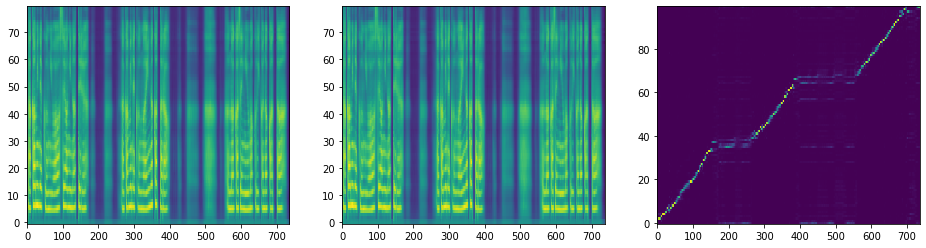

In [80]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

## Synthesize audio from spectrogram using WaveGlow

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

Save audio

In [ ]:
!mkdir results

In [ ]:
audio_path = '/content/Tacotron2-Waveglow/results/只因你太美.wav'
write(audio_path, hparams.sampling_rate, audio[0].data.cpu().numpy())

## (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 